<strong>Описание:</strong>

Задачей является предсказание потребляемой мощности горнодобывающей электротехники (экскаваторы "А" и "Б" одинаковой модели). Целью данного предсказания является анализ возможности применения контроллеров на базе нейронных сетей, для управления системой накопления энергии, регулирующей и сглаживающей резкопеременный график нагрузки. 

Мощность нагрузки данной техники имеет резкопеременный и стоахастический характер. Набор данных состоит из осцилограмм основных режимных параметров ковшового экскаватора. Интервал выборки на осциллограммах 250 мкс (80 точек на период промышленной частоты 50 Гц). В качестве тренировочных и тестовых данных будут использованы данные экскаватора "А", а для валидации полученных результатов будут использованы данные экскаватора "Б".

В файле "train_dataset.csv" содержатся данные экскаватора "А", где: первое значение -- относительное время, второе-четвертое -- напряжения А, В, С, пятое-седьмое -- токи А, В, С, восьмое -- трёхфазная мощность (значения в В, А, Вт соответственно).

В файле "validation_dataset.csv" содержатся данные экскаватора "Б", где записана только трёхфазная мощность в Вт.

In [536]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam, Nadam
from keras.layers.advanced_activations import *
from keras import regularizers
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split

<strong>Основная информация о данных первого экскаватора (тренировочный / тестовый датасет):</strong>

In [537]:
df1 = pd.read_csv('train_dataset.csv', header=None)
df1.head()

,0,1,2,3,4,5,6,7
0,-98.52075,4857.276,-3936.465,-782.689,2.050033,0.000000,0.000000,9.993429
1,-98.52050,4972.377,-3614.182,-1151.013,0.000000,-2.050033,0.000000,7.435869
2,-98.52025,5087.479,-3360.959,-1611.419,0.000000,-2.050033,0.000000,6.914885
3,-98.52000,5133.520,-2992.635,-2002.763,0.000000,4.100067,2.050033,-16.434690
4,-98.51975,5202.580,-2647.331,-2348.067,4.100067,0.000000,2.050033,16.576780


In [588]:
df1.shape

(4070030, 7)

In [539]:
df1.columns = ['old_time', 'U_a', 'U_b', 'U_c', 'I_a', 'I_b', 'I_c', 'P']
df1.head()

,old_time,U_a,U_b,U_c,I_a,I_b,I_c,P
0,-98.52075,4857.276,-3936.465,-782.689,2.050033,0.000000,0.000000,9.993429
1,-98.52050,4972.377,-3614.182,-1151.013,0.000000,-2.050033,0.000000,7.435869
2,-98.52025,5087.479,-3360.959,-1611.419,0.000000,-2.050033,0.000000,6.914885
3,-98.52000,5133.520,-2992.635,-2002.763,0.000000,4.100067,2.050033,-16.434690
4,-98.51975,5202.580,-2647.331,-2348.067,4.100067,0.000000,2.050033,16.576780


In [540]:
df1.isna().any()

old_time    False
U_a         False
U_b         False
U_c         False
I_a         False
I_b         False
I_c         False
P           False
dtype: bool

Пропусков (значений NaN) в данных нет.

In [541]:
time = np.arange(0, df1.shape[0]*0.00025, 0.00025, dtype=float)
df1 = df1.drop(columns=['old_time'], axis = 1)
df1.index = time
df1.head()

,U_a,U_b,U_c,I_a,I_b,I_c,P
0.00000,4857.276,-3936.465,-782.689,2.050033,0.000000,0.000000,9.993429
0.00025,4972.377,-3614.182,-1151.013,0.000000,-2.050033,0.000000,7.435869
0.00050,5087.479,-3360.959,-1611.419,0.000000,-2.050033,0.000000,6.914885
0.00075,5133.520,-2992.635,-2002.763,0.000000,4.100067,2.050033,-16.434690
0.00100,5202.580,-2647.331,-2348.067,4.100067,0.000000,2.050033,16.576780


Присваивание индексам абсолютного значения времени, учитывая, что интервал выборки на осциллограммах равен 250 мкс. При этом относительное время в рамках данной задачи нас не интересует.

In [542]:
df1[df1.index < 0.02].shape

(80, 7)

In [543]:
df1.describe().T

,count,mean,std,min,25%,50%,75%,max
U_a,4070030.0,8.195148,3465.673620,-5248.6210,-3430.02000,0.000000,3453.04000,5248.6210
U_b,4070030.0,8.217913,3465.669425,-5248.6210,-3430.02000,0.000000,3453.04000,5248.6210
U_c,4070030.0,27.784549,3538.070304,-5340.7020,-3522.10100,23.020270,3568.14100,5363.7220
I_a,4070030.0,2.472794,80.701732,-522.7585,-53.30087,2.050033,57.40093,565.8092
I_b,4070030.0,1.129770,78.265497,-487.9079,-51.25083,0.000000,55.35090,637.5604
I_c,4070030.0,1.129300,78.265268,-487.9079,-51.25083,0.000000,55.35090,637.5604
P,4070030.0,719.089580,327.893070,-553.9485,431.37510,700.582000,973.15160,3326.3440


Проверка правильности временной разметки индексов (в одном периоде промышленной частоты должно быть 80 значений), и основные статистические сведения о данных.

<strong>Визуализация исходных данных:</strong>

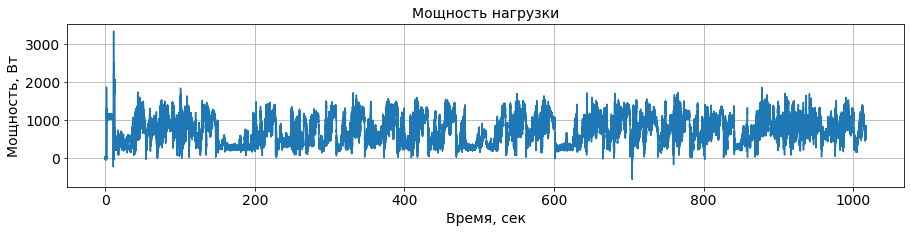

In [544]:
plt.figure(figsize=(15,3))
plt.plot(df1.P)
plt.grid()
plt.title('Мощность нагрузки', size = 14)
plt.ylabel('Мощность, Вт', size = 14)
plt.xlabel('Время, сек', size = 14)
plt.xticks(fontsize=14, rotation=0)
plt.yticks(fontsize=14, rotation=0)
plt.show()

В начальный момент времени наблюдается скачок мощности (до 3326 Вт), что, вероятно сигнализирует о пуске экскаватора. Необходимо рассмотреть более детально начальный момент времени.

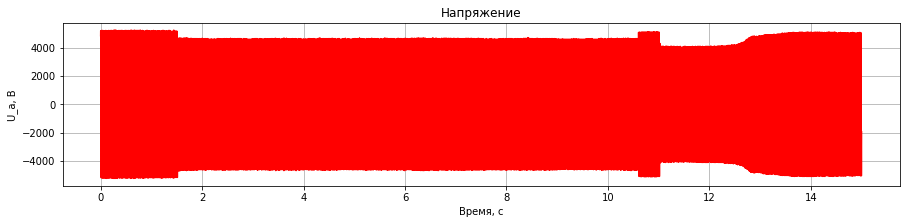

In [545]:
df1.loc[df1.index < 15].U_a.plot(
    figsize=(15,3),
    xlabel='Время, с',
    ylabel='U_a, В',
    grid=True, color='red',
    title='Напряжение');

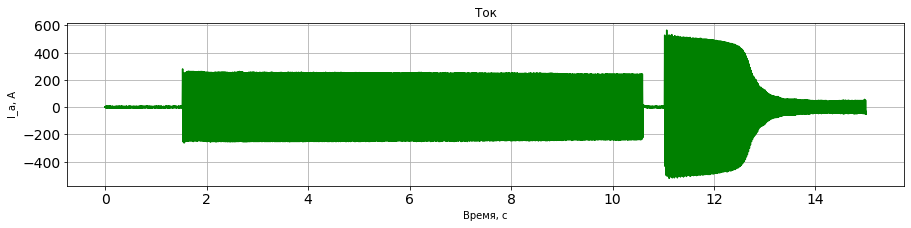

In [546]:
df1.loc[df1.index < 15].I_a.plot(
    figsize=(15,3),
    xlabel='Время, с',
    ylabel='I_a, А',
    grid=True, color='green',
    title = 'Ток',fontsize=14);

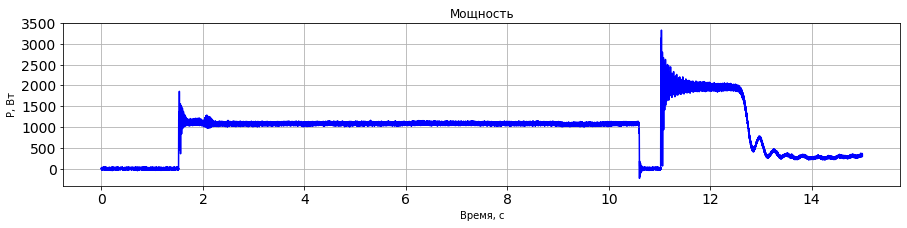

In [547]:
df1.loc[df1.index < 15].P.plot(
    figsize=(15,3),
    xlabel='Время, с',
    ylabel='P, Вт',
    grid=True, color='blue',
    title = 'Мощность',fontsize=14);

При рассмотрении первых 15 секунд, можно сделать вывод, что на интервале 0-1.5 с. экскаватор находится на холостом ходу. На 1.5 с. происходит пуск, что обуславливает скачок потребляемой мощности. В интервале времени (1.5 - 10.5 с.) происходит постоянная нагрузка без колебаний, которая не характерна при выполнении "типовой" работы экскаватор, возможно, в данный промежуток времени экскаватор переезжал, поскольку после этого наблюдается спад потребляемой мощности. А с 11 с. начинается пуск и выполнение полноценной работы.

<strong>Написание функций, для удобства дальнейшей работы</strong>

In [548]:
def initialization_of_df(df, start_int=0, end_int=10**5):
    """Функция для выбора  требуемого интервала времени из имеющегося датасета.
    А также для построение графика мощности в выбранном интервале времени.
    
    Параметры
    ---------
    df: pandas DataFrame
        Датасет имеющий столбец "P"
    start_int: int, optional
        Начало интервала
    end_int: int
        Конец интервала, optional
    interval_of_df: pandas Series
        Серия содержащая значения мощности в выбранном интервале времени
    """
    
    # Выбор интервала в соответствии с заданными параметрами
    interval_of_df = df.P.loc[(df.index >= start_int) & (df.index < end_int)]
    
    # Построение графика мощности
    plt.figure(figsize=(15,3))
    plt.plot(interval_of_df)
    plt.grid()
    plt.title('Мощность нагрузки на заданном интервале времени', size = 14)
    plt.ylabel('Мощность, Вт', size = 14)
    plt.xlabel('Время, сек', size = 14)
    plt.xticks(fontsize=14, rotation=0)
    plt.yticks(fontsize=14, rotation=0)
    plt.show()
    
    return interval_of_df

In [549]:
def slidering_window(interval_of_df, step_size = 5):
    """Функция для подготовки данных методом скользящего окна, 
        для дальнешей их обработки нейронной сетью.

    ---------
    interval_of_df: pandas Series
        Серия содержащая значения мощности
    step_size: int, optional
        Размер окна
    X_df: numpy.ndarray
        Массив фичей
    y_df: numpy.ndarray
        Массив лейблов
    """
        
  
    # Создание массива из серии
    window_power = np.array(interval_of_df)
    
    # Создание массива фичей и лейблов
    X_df = np.zeros((window_power.shape[0]-step_size,step_size))
    y_df = np.zeros(window_power.shape[0]-step_size)
    for i in range(window_power.shape[0]-step_size-1):
        X_df[i,:] = window_power[i:i+step_size]
        y_df[i] = window_power[i+step_size]
    
    # Удаления последней строки массивов (нулей)
    X_df = X_df[:-1,:]
    y_df = y_df[:-1]
    return X_df, y_df

In [550]:
def mape(y_true, y_pred):
    """Функция для расчета MAPE 
    (Mean absolute percentage error - Средняя абсолютная ошибка в процентах)
    y_true: numpy.ndarray
        Истинные значения
    y_pred: numpy.ndarray
        Предсказанные значения
    """

    return np.mean(np.abs((y_pred-y_true)/y_true))

In [551]:
def predicting_and_stats(X_test, y_test):
    """Функция для предсказания значений НС,
    построения графика истинных и предсказанных значений мощности,
    и вывода следующих статистических параметров:
        MAE - Mean absolute error (средняя абсолютная ошибка)
        MAPE - Mean absolute percentage error (средняя абсолютная ошибка в процентах)
        RMSE - Root mean square error (корень среднеквадратической ошибки)
    X_test: numpy.ndarray
        Значения фичей
    y_test: numpy.ndarray
        Значения лейблов
    """
    
    # предсказание лейблов
    y_pred = model.predict(X_test)
    
    # задание интервала времени для построения графика
    time_pred =  np.arange( 0, np.size(y_pred)*0.00025, 0.00025 )
    
    # построение итогового графика
    plt.figure(figsize=(15,3))
    plt.plot(time_pred, y_pred, '-b', label='Предсказание')
    plt.plot(time_pred, y_test, '-g', label='Действительное', alpha = 0.5)
    plt.grid()
    plt.title('Часть графика нагрузки', size=20)
    plt.ylabel('Мощность, Вт', size=16)
    plt.xlabel('Время, сек', size=16)
    plt.legend(frameon=True, loc=0, prop={'size': 10})
    plt.xticks(fontsize=16, rotation=0)
    plt.yticks(fontsize=16, rotation=0)
    plt.show()
    
    # вывод статистических параметров
    print(f"MAE: {mean_absolute_error(y_test, y_pred.flatten())}")
    print(f"MAPE: {mape(y_test, y_pred.flatten())}")
    print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred.flatten()))}")

<strong>Выбор интервала для обучения НС:</strong>

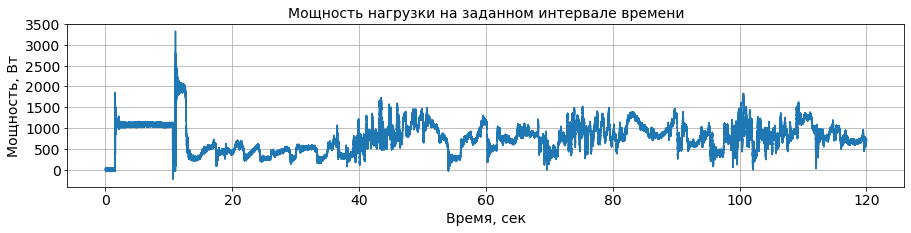

In [552]:
interval_of_df1 = initialization_of_df(df1, 0, 120)

Для обучения НС был выбран интервал (0 - 120 с.), поскольку в нём имеется максимальный размах возможных значений.

<strong>Подготовка данных методом скользящего окна, с размером окна равным 5:</strong>

In [553]:
X_df1, y_df1 = slidering_window(interval_of_df1, 5)

<strong>Создание и обучение нейронной сети:</strong>

In [571]:
# Разбиение данных на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X_df1, y_df1, test_size=0.2, shuffle=False)

# Модель - многослойный перцептрон
model = Sequential()

# Входной и первый слой
model.add(Dense(15, input_dim=5, activity_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization()) 
model.add(Activation('selu')) 
model.add(Dropout(0.15)) 

# Второй слой
model.add(Dense(10, activity_regularizer=regularizers.l2(0.01))) #
model.add(BatchNormalization())
model.add(Activation('selu'))
model.add(Dropout(0.15))

# Третий слой
model.add(Dense(5, activity_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(Activation('selu'))

# Выходной слой
model.add(Dense(1))
model.add(Activation('linear'))

# Компиляция 
model.compile(loss='mean_squared_error', optimizer='adam')

# Обучение
model.fit(X_train, y_train, epochs=4, batch_size=25);

Epoch 1/4
15360/15360 [==============================] - 15s 856us/step - loss: 454075.9861
Epoch 2/4
15360/15360 [==============================] - 13s 844us/step - loss: 13758.0886
Epoch 3/4
15360/15360 [==============================] - 13s 848us/step - loss: 11273.5636
Epoch 4/4
15360/15360 [==============================] - 13s 853us/step - loss: 11169.1251


<strong>Предсказание значений для тестовой выборки:</strong>

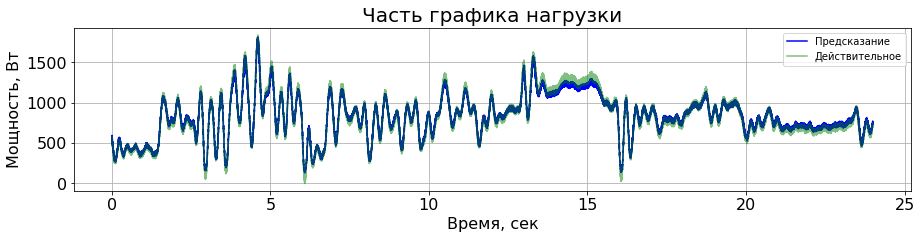

MAE: 28.687898117438788
MAPE: 0.04625777673089706
RMSE: 35.62287484770132


In [572]:
predicting_and_stats(X_test, y_test)

Визуально можно заметить, что НС довольно точно предсказывает значения мощность нагрузки. 

Значение MAPE ~5%, что говорит о том, что точность прогнозирования составляет ~95%.

<strong>Проверка работы НС на интервале, который не был задействован в обучении:</strong>

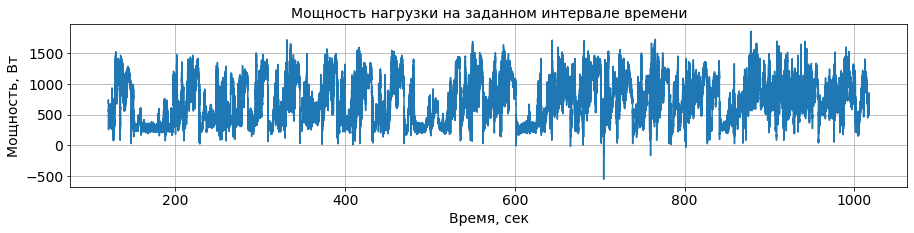

In [576]:
special_interval_of_df1 = initialization_of_df(df1, 121, 1100)

In [577]:
special_X_df1, special_y_df1 = slidering_window(special_interval_of_df1, 5)

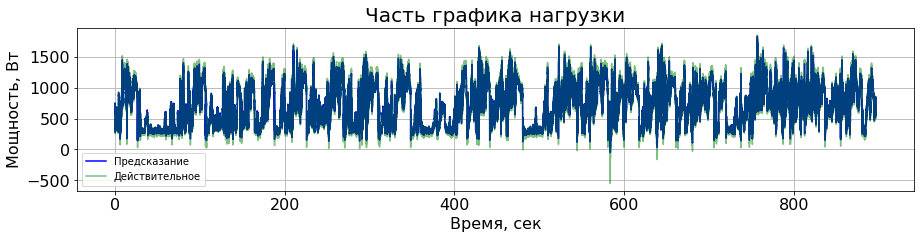

MAE: 25.886972527991865
MAPE: 0.04532837337451991
RMSE: 32.69282814805511


In [578]:
predicting_and_stats(special_X_df1, special_y_df1)

И для данного интервала времени НС давольно точно предсказала значения мощности нагрузки. Значения статистических метрик близки к тем, что были получены на тестовой выборке. Точность прогнозирования также составляет ~95%.

<strong>Основная информация о данных второго экскаватора (валидационный датасет):</strong>

In [579]:
validation_data = pd.read_csv('validation_dataset.csv', header=None)
validation_data.head()

,0
0,1027.429
1,1040.311
2,1037.801
3,1038.511
4,1029.418


In [589]:
validation_data.shape

(797820, 1)

In [580]:
validation_data.isna().any()

0    False
dtype: bool

In [581]:
validation_data_time = np.arange(0, validation_data.shape[0]*0.00025, 0.00025, dtype=float)
validation_data.index = validation_data_time
validation_data.columns = ['P']
validation_data.head()

,P
0.00000,1027.429
0.00025,1040.311
0.00050,1037.801
0.00075,1038.511
0.00100,1029.418


In [582]:
validation_data[validation_data.index < 0.02].shape

(80, 1)

In [583]:
validation_data.describe().T

,count,mean,std,min,25%,50%,75%,max
P,797820.0,1079.649722,392.12966,14.63492,726.1577,1132.383,1389.418,2006.737


Проверка и подготовка исходных данных, аналогично тренировочному датасету.

<strong>Визуализация исходных данных:</strong>

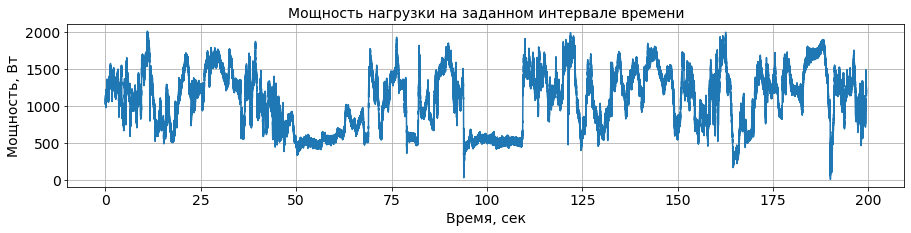

In [584]:
interval_of_validation_data = initialization_of_df(validation_data)

In [585]:
X_validation, y_validation = slidering_window(interval_of_validation_data, 5)

<strong>Проверка работы НС на валидационном наборе данных, который ранее не был задействован:</strong>

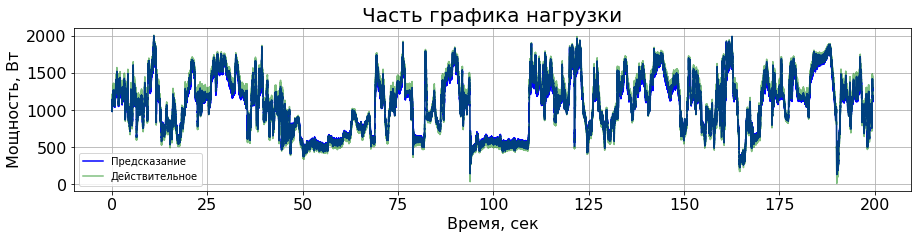

MAE: 38.84872950928362
MAPE: 0.03833198065624106
RMSE: 46.07899586275442


In [586]:
predicting_and_stats(X_validation, y_validation)

На валидационном наборе данных НС показала высокую точность предсказания (~95%). 

Значения статистических метрик близки к значениям полученным на тестовом наборе данных. 

Точность предсказания данной НС является приемлемой для применения данной модели в контроллерах, для управления системой накопления энергии, регулирующей и сглаживающей резкопеременный график нагрузки.